<a href="https://colab.research.google.com/github/jakubkarczewski/KaggleNotebooks/blob/master/dog_breed_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook solves the task of identyfying dog breed (dataset was a subset of official Kaggle [competition](https://www.kaggle.com/c/dog-breed-identification))

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp -a "/content/gdrive/My Drive/doges/etipgdlaex2.zip" "./dataset.zip"

In [0]:
!rm -rf test
!rm -rf train
!rm -f test.csv
!rm -f dump.thrash
!unzip dataset.zip > dump.thrash

In [0]:
!rm -rf "./CLR"
!git clone https://github.com/bckenstler/CLR.git

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 1.50 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [0]:
!cp "/content/CLR/clr_callback.py" .

In [0]:
# data science libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
sns.set_style('whitegrid')

# Keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

# CLR
from clr_callback import *

Using TensorFlow backend.


In [0]:
# constants
DATA_DIR = '.'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
BATCH_SIZE = 128
INPUT_SIZE = 299
NUM_CLASSES = 20
SEED = 1

In [0]:
# define model architecture
def get_model(lr=0.0001):
    """Returns InceptionResNetV2 based model ready for transfer learning."""
    
    model = Sequential()
    base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                                   input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    sgd = SGD(lr=0.1, momentum=0.95, nesterov=False)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1)


train_generator = train_datagen.flow_from_directory(
                                                directory=TRAIN_DIR,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                target_size=(INPUT_SIZE,
                                                             INPUT_SIZE),
                                                subset='training'                                                
                                               )

valid_generator = train_datagen.flow_from_directory(
                                                directory=TRAIN_DIR,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                target_size=(INPUT_SIZE,
                                                             INPUT_SIZE),
                                                subset='validation'
                                               )

Found 1366 images belonging to 20 classes.
Found 143 images belonging to 20 classes.


In [0]:
# handle lack of balance in different classes
import collections
counter = collections.Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id,
                 num_images in counter.items()}                     

In [0]:
# find optimal min and max LR values via CLR
gc.collect()

model = get_model()

train_generator.reset()
valid_generator.reset()

STEP_SIZE_TRAIN = train_generator.samples // BATCH_SIZE
STEP_SIZE_VALID =  valid_generator.samples // BATCH_SIZE

EPOCHS = 1
base_lr=0.0001
max_lr=1
step_size = EPOCHS * STEP_SIZE_TRAIN 
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size)
model.fit_generator(train_generator, 
                              epochs=EPOCHS, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
#                               class_weight=class_weights,
                              callbacks=[clr]
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10/10 [==============================] - 64s 6s/step - loss: 2.5293 - acc: 0.5187 - val_loss: 0.6797 - val_acc: 0.8828


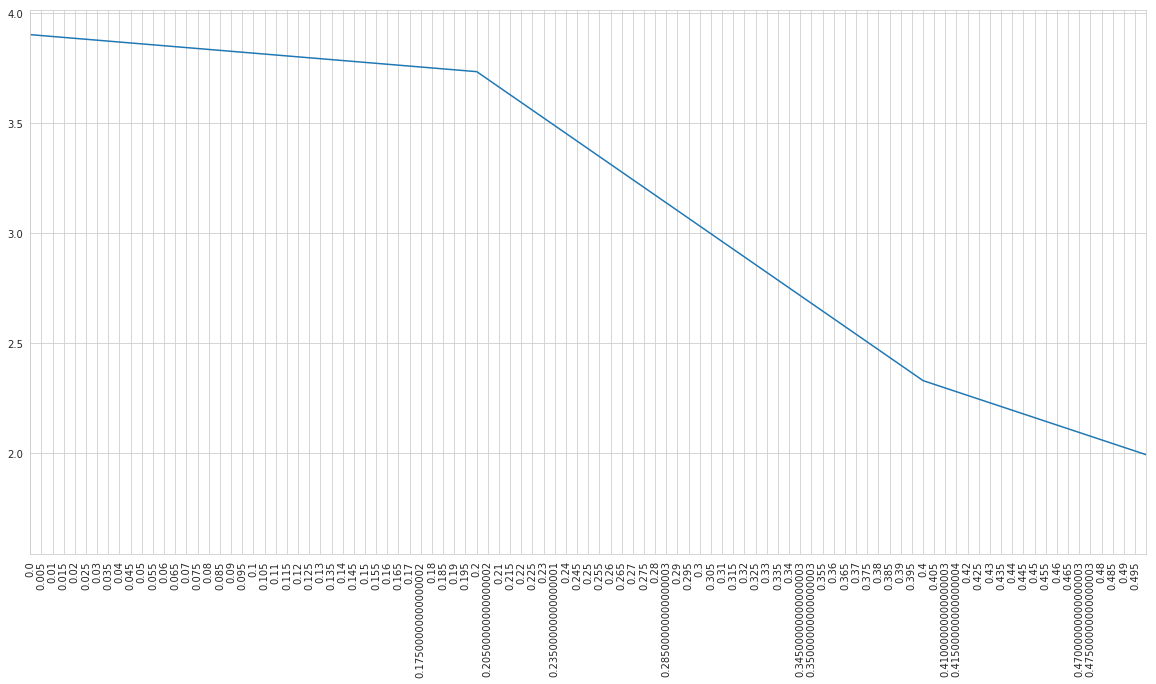

In [0]:
results = pd.DataFrame(clr.history)
lr = results['lr']
loss = results['loss']
window=1
rolling_loss = loss.rolling(window).mean().fillna(0)

fig = plt.figure(figsize=(20, 10))
ticks = np.arange(0, 0.5, 0.005)
labels = ticks
plt.xticks(ticks, ticks, rotation='vertical')
plt.tick_params(axis='x', which='minor', colors='black')
plt.xlim(0,0.5)
till=500
plt.plot(lr[::2], loss[::2])
plt.show()

In [0]:

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                30740     
Total params: 54,367,476
Trainable params: 30,740
Non-trainable params: 54,336,736
_________________________________________________________________


In [0]:
gc.collect()


EPOCHS = 40

STEP_SIZE_TRAIN = train_generator.samples // BATCH_SIZE
STEP_SIZE_VALID =  valid_generator.samples // BATCH_SIZE

train_generator.reset()
valid_generator.reset()

# callbacks for CyclicLR, checkpointing
clr = CyclicLR(base_lr=0.04, max_lr=0.11, step_size=2*STEP_SIZE_TRAIN,
               mode='triangular')
checkpoint = ModelCheckpoint('dog_breed_inceptionv3.hf5', monitor='val_acc',
                             verbose=0, save_best_only=True, mode='max',
                             save_weights_only=False)

# run actual training
history = model.fit_generator(train_generator, 
                              epochs=EPOCHS, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
#                               class_weight=class_weights,
                              callbacks=[checkpoint, clr]
                            
                             )

Epoch 1/40
10/10 [==============================] - 62s 6s/step - loss: 2.4670 - acc: 0.4992 - val_loss: 0.2186 - val_acc: 0.9453
Epoch 2/40
10/10 [==============================] - 35s 4s/step - loss: 0.3409 - acc: 0.9311 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3/40
10/10 [==============================] - 31s 3s/step - loss: 0.3211 - acc: 0.9306 - val_loss: 0.0567 - val_acc: 0.9688
Epoch 4/40
10/10 [==============================] - 34s 3s/step - loss: 0.2806 - acc: 0.9466 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 5/40
10/10 [==============================] - 40s 4s/step - loss: 0.2561 - acc: 0.9547 - val_loss: 0.0356 - val_acc: 0.9766
Epoch 6/40
10/10 [==============================] - 35s 3s/step - loss: 0.1385 - acc: 0.9722 - val_loss: 0.0397 - val_acc: 1.0000
Epoch 7/40
10/10 [==============================] - 40s 4s/step - loss: 0.1325 - acc: 0.9673 - val_loss: 0.0945 - val_acc: 0.9609
Epoch 8/40
10/10 [==============================] - 35s 3s/step - loss: 0.1328 - acc: 0.96

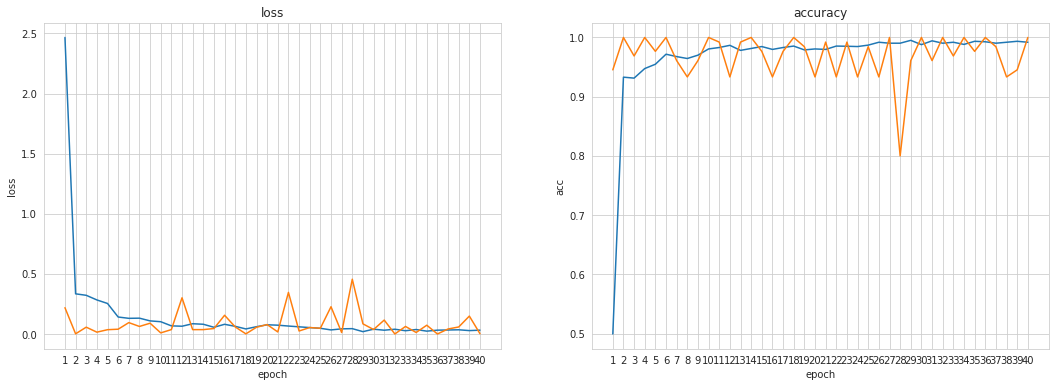

In [0]:
def plot_history(history, metric, title, ax, val=True):
    ax.plot(history[metric])
    
    if val:
        ax.plot(history['val_' + metric])
        
    ax.grid(True)
    ax.set_title(title)
    ax.xaxis.set_ticks(range(0,EPOCHS))
    ax.xaxis.set_ticklabels([str(i) for i in range(1,EPOCHS+1)])
    

    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    
    
hist = history.history
fig, ax = plt.subplots(1,2, figsize=(18,6))
plot_history(hist, 'loss', 'loss', ax[0])
plot_history(hist, 'acc', 'accuracy', ax[1])
plt.savefig('history.png')

In [0]:
# generate submission file
test_df = pd.read_csv('test.csv')
test_df['filenames']=test_df['id']+'.jpg'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    'test',
    x_col='filenames',
    target_size=(INPUT_SIZE, INPUT_SIZE),
    class_mode=None,
    shuffle = False,
    batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)
id_to_breed = {y:x for x,y in train_generator.class_indices.items()}
predictions = np.argmax(predict,axis=1)
predictions = list(map(lambda x: id_to_breed[x],predictions))
test_df['breed']=''
for i in range(len(filenames)):
    test_df.at[i,'breed']= predictions[filenames.index(test_df.at[i,'filenames'])]

predictions=np.column_stack((np.array(test_df.id),np.array(predictions)))
test_df.drop('filenames',axis=1).to_csv("submission.csv",header=True, index=False)

Found 179 images.
